# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük az alábbi szerzőt értesíteni.

2016 (c) Tóth Bálint Pál (toth.b kukac tmit pont bme pont hu)
</PRE>

# Szinusz modellezése LSTM-el
Ebben a notebookban bemutatjuk, hogy hogyan lehet összerakni egy vektorból LSTM háló számmára szükséges (nb_samples, timesteps, input_dim) alakú bemenetet és azt, hogy hogyan tudjuk tanítani a hálót. Vegyük észre, hogy a bemenő adat struktúrája azonos az 1D konvolúciónál megismertekkel (lásd: 08 gyakorlat anyaga). A be- és kimenetek előkészítése ezért teljesen analóg módon történik, egyedül a modellben az 1D konvolúciós és dropout rétegeket cseréljük le egy {LSTM_units} darab LSTM egységet tartalmazó egyirányú LSTM rétegre.

In [1]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation, Flatten

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sample_points = 10 # az előadás fóliáin "m"-el jelöltük (FrameSize)
shift = 2 # az előadás fóliáin "s"-el jelöltük

lins = np.linspace(0,np.pi*10,4000)
data = np.asarray([np.sin(lins)]).T # egy sin és egy cos adatsor létrehozása
nb_samples = len(data) - sample_points - 1 # a minták száma, ha nem lenne "shift", azt majd három sorral lentebb vesszük figyelembe

# standardizálás
std_scaler = StandardScaler()
lins = std_scaler.fit_transform(lins)
# normalizálás
mm_scaler = MinMaxScaler(feature_range=(0, 1))
data = mm_scaler.fit_transform(data)

# bemenet létrehozása - a sin és cos sample_points pillanatban, shift lépésenként
# atleast_2d: legalább 2D-s mátrixokká alakítja a bemenetet, jelen esetben (50,2) alakú
# expand_dims: növeli a dimenzió számot a megadott axis mentén, így lesz jelen esetben (1,50,2) alakú mintánk, 
#              amiket majd egymás után fűzve hozzuk létre a tanítóadatokat
input_list = [np.expand_dims(np.atleast_2d(np.asarray([lins[i:i+sample_points]]).T), axis=0) for i in range(0,nb_samples,shift)]
X = np.concatenate(input_list, axis=0)
print("Bemenet alakja: ")
print(X.shape)

# az első öt bemeneti tanítóminta kiiratás
for i in range(0,5):
    print("\n"+str(i+1)+". bemeneti tanítóminta:")
    print(X[i])

Using Theano backend.


Bemenet alakja: 
(1995, 10, 1)

1. bemeneti tanítóminta:
[[-1.73161785]
 [-1.73075182]
 [-1.7298858 ]
 [-1.72901977]
 [-1.72815375]
 [-1.72728772]
 [-1.7264217 ]
 [-1.72555567]
 [-1.72468965]
 [-1.72382362]]

2. bemeneti tanítóminta:
[[-1.7298858 ]
 [-1.72901977]
 [-1.72815375]
 [-1.72728772]
 [-1.7264217 ]
 [-1.72555567]
 [-1.72468965]
 [-1.72382362]
 [-1.72295759]
 [-1.72209157]]

3. bemeneti tanítóminta:
[[-1.72815375]
 [-1.72728772]
 [-1.7264217 ]
 [-1.72555567]
 [-1.72468965]
 [-1.72382362]
 [-1.72295759]
 [-1.72209157]
 [-1.72122554]
 [-1.72035952]]

4. bemeneti tanítóminta:
[[-1.7264217 ]
 [-1.72555567]
 [-1.72468965]
 [-1.72382362]
 [-1.72295759]
 [-1.72209157]
 [-1.72122554]
 [-1.72035952]
 [-1.71949349]
 [-1.71862747]]

5. bemeneti tanítóminta:
[[-1.72468965]
 [-1.72382362]
 [-1.72295759]
 [-1.72209157]
 [-1.72122554]
 [-1.72035952]
 [-1.71949349]
 [-1.71862747]
 [-1.71776144]
 [-1.71689542]]


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [2]:
# kimenet létrehozása a fentiek szerint 
# mindig a következő időpillanatban jósolja előre a sin értékét
target_list = [np.atleast_2d(data[i+sample_points+1]) for i in range(0,nb_samples,shift)]
y = np.concatenate(target_list, axis=0)
print("\nKimenet alakja: ")
print(y.shape)

# az első öt kimeneti tanítóminta kiiratás
for i in range(0,5):
    print("\n"+str(i+1)+". kimeneti tanítóminta:")
    print(y[i])


Kimenet alakja: 
(1995, 1)

1. kimeneti tanítóminta:
[ 0.54315395]

2. kimeneti tanítóminta:
[ 0.55097493]

3. kimeneti tanítóminta:
[ 0.55878333]

4. kimeneti tanítóminta:
[ 0.56657722]

5. kimeneti tanítóminta:
[ 0.57435467]


## Modell létrehozása
Ezután létrehozzuk a modellt Sequential objektumként és összesen egy darab LSTM réteget rakunk bele 64 LSTM egységgel. 

In [3]:
LSTM_units=64
model = Sequential()
model.add(LSTM(LSTM_units, input_shape=(X.shape[-2],X.shape[-1])))

## Előrecsatolt réteg
Az LSTM réteg után egy előrecsatolt réteget kötünk az 1D konvolúcióhoz hasonlóan: 

In [4]:
model.add(Dense(1, activation='linear'))

Ezt követően lefordítjuk a modellet (négyzete hiba a költségfüggvényt + Adam optimizációt használunk) és betanítjuk, most negyven darab epochig. A fit függvény a minták keverését is elvégzi nekünk. 

In [5]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, nb_epoch=40, shuffle=True)

Epoch 1/40
1995/1995 [==============================] - 0s - loss: 0.1550     
Epoch 2/40
1995/1995 [==============================] - 0s - loss: 0.1227     
Epoch 3/40
1995/1995 [==============================] - 0s - loss: 0.1218     
Epoch 4/40
1995/1995 [==============================] - 0s - loss: 0.1218     
Epoch 5/40
1995/1995 [==============================] - 0s - loss: 0.1205     
Epoch 6/40
1995/1995 [==============================] - 0s - loss: 0.1187     
Epoch 7/40
1995/1995 [==============================] - 0s - loss: 0.1189     
Epoch 8/40
1995/1995 [==============================] - 0s - loss: 0.1181     
Epoch 9/40
1995/1995 [==============================] - 0s - loss: 0.1175     
Epoch 10/40
1995/1995 [==============================] - 0s - loss: 0.1159     
Epoch 11/40
1995/1995 [==============================] - 0s - loss: 0.1111     
Epoch 12/40
1995/1995 [==============================] - 0s - loss: 0.1070     
Epoch 13/40
1995/1995 [==========================

Miután kész a tanítás készítünk egy predikciót, a kapott értékeket "visszaskálázzuk" és ezt rajzoljuk ki. 

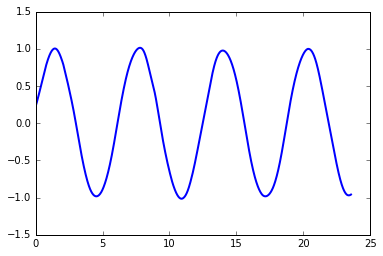

In [6]:
Y_predicted = model.predict(X, batch_size=100)
line, = plt.plot(std_scaler.inverse_transform(lins[0:3000:shift]), \
                 mm_scaler.inverse_transform(Y_predicted[0:int(3000/shift)]), \
                 '-', linewidth=2)